In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
!pip install rasterio -q
!pip install geopandas -q
!pip install xgboost -q
!pip install skranger -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.7 MB/s eta 0:00:00


In [ ]:
import importlib.util

spec = importlib.util.spec_from_file_location("script", '/content/MyDrive/MyDrive/GEE_SOP/modules/script.py')
script_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(script_module)

script_module.Script.work()

it's working!


In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import RidgeCV, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor , BaggingRegressor, StackingRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from skranger.ensemble import RangerForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score

from sklearn.linear_model import Lasso, Ridge

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
!ls /content/MyDrive/MyDrive/GEE_SOP

Area_0709_2017.tif  Datasets.csv	model_carbon_prediction_v1.joblib  sentinel2_1112_2016.tif
BARY		    DIOHENE		model_carbon_prediction_v2.joblib  sentinel2_2024.tif
Bary.csv	    Diohene.csv		modules				   SOP
BaryMNT.tif	    DioheneMNT.tif	sentinel2_0607_2016.tif		   Sop.csv
BaryTIF2017.tif     DioheneTIF2017.tif	sentinel2_0709_2017.tif		   SopMNT.tif
Dataset		    MNT.tif		sentinel2_0810_2016.tif		   SopTIF2017.tif


In [ ]:
dataset = gpd.read_file('/content/MyDrive/MyDrive/GEE_SOP/Dataset/Datasets.shp')

In [ ]:
dataset = dataset.drop(columns=['field_1','Site'])
dataset['Date'] = pd.to_datetime(dataset['Date'], dayfirst=True)
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Stock_C (M'] = dataset['Stock_C (M'].str.replace(',', '.').astype(float)
dataset['Epaisseur_'] = dataset['Epaisseur_'].astype(float)
dataset['Profondeur'] = dataset['Profondeur'].astype(float)

dataset = dataset.rename(columns={'Stock_C (M':'Carbon','Epaisseur_':'Epaisseur'})
dataset = dataset.drop(columns=['Date'])

In [ ]:
columns_0607_2016 = ['B_0607_201','B_0607_2_1','B_0607_2_2','B_0607_2_3','B_0607_2_4','B_0607_2_5','B_0607_2_6','B_0607_2_7','B_0607_2_8','B_0607_2_9','B_0607_210','B_0607_211','B_0607_212']
columns_0810_2016 = ['B_0810_201','B_0810_2_1','B_0810_2_2','B_0810_2_3','B_0810_2_4','B_0810_2_5','B_0810_2_6','B_0810_2_7','B_0810_2_8','B_0810_2_9','B_0810_210','B_0810_211','B_0810_212']
columns_1112_2016 = ['B_1112_201','B_1112_2_1','B_1112_2_2','B_1112_2_3','B_1112_2_4','B_1112_2_5','B_1112_2_6','B_1112_2_7','B_1112_2_8','B_1112_2_9','B_1112_210','B_1112_211','B_1112_212']
columns_0709_2017 = ['B_0709_201','B_0709_2_1','B_0709_2_2','B_0709_2_3','B_0709_2_4','B_0709_2_5','B_0709_2_6','B_0709_2_7','B_0709_2_8','B_0709_2_9','B_0709_210','B_0709_211','B_0709_212']

# Combiner les listes de colonnes
columns_0810_1112_0709 = columns_0810_2016 + columns_1112_2016 + columns_0709_2017
columns_0607_1112_0709 = columns_0607_2016 + columns_1112_2016 + columns_0709_2017
columns_0607_0810_0709 = columns_0607_2016 + columns_0810_2016 + columns_0709_2017
columns_0607_0810_1112 = columns_0607_2016 + columns_0810_2016 + columns_1112_2016

df_0607_2016  = dataset.drop(columns=columns_0810_1112_0709)[(dataset['Year'] == 2016) & (dataset['Month'].isin([6, 7]))]
df_0810_2016  = dataset.drop(columns=columns_0607_1112_0709)[(dataset['Year'] == 2016) & (dataset['Month'].isin([8, 9]))]
df_1112_2016  = dataset.drop(columns=columns_0607_0810_0709)[(dataset['Year'] == 2016) & (dataset['Month'] == 11)]
df_0709_2017  = dataset.drop(columns=columns_0607_0810_1112)[(dataset['Year'] == 2017) & (dataset['Month'] == 8)]

df_0607_2016.rename(columns=lambda x: x.replace('B_0607_2', 'B'), inplace=True)
df_0810_2016.rename(columns=lambda x: x.replace('B_0810_2', 'B'), inplace=True)
df_1112_2016.rename(columns=lambda x: x.replace('B_1112_2', 'B'), inplace=True)
df_0709_2017.rename(columns=lambda x: x.replace('B_0709_2', 'B'), inplace=True)

part1 = pd.concat([df_0607_2016, df_0810_2016],axis=0)
part2 = pd.concat([df_1112_2016, df_0709_2017],axis=0)
final_dataset = pd.concat([part1, part2],axis=0)
final_dataset  = final_dataset.drop(columns=['Month','Year'])

final_dataset = final_dataset.rename(columns={'B01':'B_1','B_1':'B_2','B_2':'B_3','B_3':'B_4','B_4':'B_5','B_5':'B_6','B_6':'B_7','B_7':'B_8','B_8':'B_8A','B10':'B_10','B11':'B_11','B12':'B_12'})

In [ ]:
# def calculate_indices(row):
#     # Extraire les valeurs de pixel des bandes
#     B_1 = row['B_1']
#     B_2 = row['B_2']
#     B_3 = row['B_3']
#     B_4 = row['B_4']
#     B_5 = row['B_5']
#     B_6 = row['B_6']
#     B_7 = row['B_7']
#     B_8 = row['B_8']
#     B_8A = row['B_8A']
#     B_9 = row['B_9']
#     B_10 = row['B_10']
#     B_11 = row['B_11']
#     B_12 = row['B_12']

#     # Calcul du NDVI
#     ndvi = (B_8 - B_4) / (B_8 + B_4)

#     # Calcul du GDVI
#     gdvi = (B_8 - B_3) / (B_8 + B_3)

#     # Calcul du MSAVI2
#     msavi2 = (2 * B_8 + 1 - ((2 * B_8 + 1) ** 2 - 8 * (B_8 - B_4)) ** 0.5) / 2

#     # Calcul du PSRINIR
#     psrinir = B_8 / B_5

#     # Calcul du NDWI
#     ndwi = (B_3 - B_8) / (B_3 + B_8)

#     # Calcul du CIGreen
#     cigreen = (B_4 - B_3) / (B_4 + B_3)

#     return pd.Series({'NDVI': ndvi, 'GDVI': gdvi, 'MSAVI2': msavi2, 'PSRINIR': psrinir, 'NDWI': ndwi, 'CIGreen': cigreen})

# # Appliquer la fonction de calcul des indices à chaque ligne du dataset
# indices_df = final_dataset.apply(calculate_indices, axis=1)

# # Ajouter les colonnes des indices calculés au dataset
# final_dataset = pd.concat([final_dataset, indices_df], axis=1)

In [ ]:
#final_dataset.to_csv("/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv")

In [ ]:
final_dataset = final_dataset.drop(columns=['X_Centroid','Y_Centroid','geometry','Epaisseur'])

In [ ]:
final_dataset

Carbon  Profondeur      B_1      B_2      B_3      B_4      B_5  \
1550    4.18        10.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1551    4.13        30.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1552    5.26        10.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1553    9.16        30.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1554   11.89        10.0  0.17195  0.15525  0.16585  0.21200  0.22515   
...      ...         ...      ...      ...      ...      ...      ...   
2641    8.24        30.0  0.16600  0.16980  0.19530  0.25750  0.25210   
2642    4.88        10.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2643    7.56        30.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2644    6.71        10.0  0.16130  0.15570  0.17380  0.22290  0.21500   
2645    8.26        30.0  0.16130  0.15570  0.17380  0.22290  0.21500   

          B_6      B_7      B_8     B_8A      B_9     B_10     B_11     B_12  \
1550  0.30435  0.34395  0.32845  0.38595  0.06475  0.00245  0.51945  0.41065   
1551  0.30435  0.34395  0.32845  0.38595  0.06475  0.00245  0.51945  0.41065   
1552  0.31295  0.35765  0.33275  0.39510  0.06645  0.00245  0.53790  0.42455   
1553  0.31295  0.35765  0.33275  0.39510  0.06645  0.00245  0.53790  0.42455   
1554  0.26460  0.30620  0.28835  0.35160  0.06245  0.00245  0.47470  0.34885   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2641  0.32880  0.37690  0.35920  0.41570  0.05890  0.00180  0.44340  0.32470   
2642  0.27350  0.31270  0.30760  0.34810  0.05870  0.00180  0.40540  0.29490   
2643  0.27350  0.31270  0.30760  0.34810  0.05870  0.00180  0.40540  0.29490   
2644  0.31960  0.36300  0.35240  0.39700  0.06190  0.00180  0.40930  0.29930   
2645  0.31960  0.36300  0.35240  0.39700  0.06190  0.00180  0.40930  0.29930   

          MNT_1  
1550  12.962011  
1551  12.962011  
1552  15.547010  
1553  15.547010  
1554        NaN  
...         ...  
2641  18.997011  
2642  21.105345  
2643  21.105345  
2644  19.088678  
2645  19.088678  

[3626 rows x 16 columns]

In [ ]:
median_mnt1 = final_dataset['MNT_1'].median()
final_dataset['MNT_1'] = final_dataset['MNT_1'].fillna(median_mnt1)

In [ ]:
final_dataset.isna().sum()

Carbon        0
Profondeur    0
B_1           0
B_2           0
B_3           0
B_4           0
B_5           0
B_6           0
B_7           0
B_8           0
B_8A          0
B_9           0
B_10          0
B_11          0
B_12          0
MNT_1         0
dtype: int64

In [ ]:
# Fonction pour remplacer les valeurs aberrantes par un quantile proche
def replace_outliers_with_quantile(df, column, lower_quantile=0.05, upper_quantile=0.95):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_value = df[column].quantile(lower_quantile)
    upper_value = df[column].quantile(upper_quantile)

    df[column] = np.where(df[column] < lower_bound, lower_value, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_value, df[column])

    # # Filtrer les valeurs aberrantes
    # filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


final_dataset = replace_outliers_with_quantile(final_dataset, 'Carbon')

In [ ]:
final_dataset

Carbon  Profondeur      B_1      B_2      B_3      B_4      B_5  \
1550    4.18        10.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1551    4.13        30.0  0.17855  0.17550  0.19990  0.26885  0.27325   
1552    5.26        10.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1553    9.16        30.0  0.18155  0.17585  0.20025  0.27165  0.28350   
1554   11.89        10.0  0.17195  0.15525  0.16585  0.21200  0.22515   
...      ...         ...      ...      ...      ...      ...      ...   
2641    8.24        30.0  0.16600  0.16980  0.19530  0.25750  0.25210   
2642    4.88        10.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2643    7.56        30.0  0.16560  0.15580  0.17480  0.20700  0.21590   
2644    6.71        10.0  0.16130  0.15570  0.17380  0.22290  0.21500   
2645    8.26        30.0  0.16130  0.15570  0.17380  0.22290  0.21500   

          B_6      B_7      B_8     B_8A      B_9     B_10     B_11     B_12  \
1550  0.30435  0.34395  0.32845  0.38595  0.06475  0.00245  0.51945  0.41065   
1551  0.30435  0.34395  0.32845  0.38595  0.06475  0.00245  0.51945  0.41065   
1552  0.31295  0.35765  0.33275  0.39510  0.06645  0.00245  0.53790  0.42455   
1553  0.31295  0.35765  0.33275  0.39510  0.06645  0.00245  0.53790  0.42455   
1554  0.26460  0.30620  0.28835  0.35160  0.06245  0.00245  0.47470  0.34885   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2641  0.32880  0.37690  0.35920  0.41570  0.05890  0.00180  0.44340  0.32470   
2642  0.27350  0.31270  0.30760  0.34810  0.05870  0.00180  0.40540  0.29490   
2643  0.27350  0.31270  0.30760  0.34810  0.05870  0.00180  0.40540  0.29490   
2644  0.31960  0.36300  0.35240  0.39700  0.06190  0.00180  0.40930  0.29930   
2645  0.31960  0.36300  0.35240  0.39700  0.06190  0.00180  0.40930  0.29930   

          MNT_1  
1550  12.962011  
1551  12.962011  
1552  15.547010  
1553  15.547010  
1554  14.897013  
...         ...  
2641  18.997011  
2642  21.105345  
2643  21.105345  
2644  19.088678  
2645  19.088678  

[3626 rows x 16 columns]

In [ ]:
#dataset.to_csv('/content/MyDrive/MyDrive/GEE_SOP/SOP/sop_data.csv')

In [ ]:
X = np.array(final_dataset.drop(columns=['Carbon']))
Y = np.array(final_dataset['Carbon'])

In [ ]:
X_train , X_test , Y_train , Y_test = train_test_split( X , Y , test_size=0.2 , random_state=42 )

In [ ]:
# estimator = RandomForestRegressor(random_state=42)

# # Définir la grille de paramètres à tester
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 5, 10, 15, 20, 25, 30]
# }

# # Configurer GridSearchCV
# grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,cv=3, n_jobs=-1, verbose=2)

# # Exécuter GridSearchCV
# grid_search.fit(X_train, Y_train)

# # Afficher les meilleurs hyperparamètres
# print(f"Meilleurs hyperparamètres trouvés: {grid_search.best_params_}")

# # Utiliser les meilleurs hyperparamètres pour faire des prédictions
# best_rf = grid_search.best_estimator_
# predictions = best_rf.predict(X_test)

# # Évaluer les performances du modèle
# mse = mean_squared_error(Y_test, predictions)
# print(f"Mean Squared Error sur le set de test: {mse}")

Fitting 3 folds for each of 210 candidates, totalling 630 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Meilleurs hyperparamètres trouvés: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 1000}
Mean Squared Error sur le set de test: 3.9572339767061018


In [ ]:
# Définir les modèles individuels
xgb_model = XGBRegressor( n_estimators = 100, max_depth = 5, random_state=42)
lgbmr = lgb.LGBMRegressor(n_estimators = 300, max_depth = 5, num_leaves = 50, force_col_wise=True)
gbr = GradientBoostingRegressor(n_estimators = 200, max_depth =  5)
hgb = HistGradientBoostingRegressor(max_iter=300, max_depth=5, learning_rate = 0.1, max_bins = 255, max_leaf_nodes = 31, min_samples_leaf = 20, random_state=42)
rf = RandomForestRegressor(n_estimators = 1000, max_depth = 20, max_features = 'sqrt', random_state=42)

# Créer les pipelines pour chaque modèle
xgb_pipeline = make_pipeline(StandardScaler(), xgb_model)
lgbmr_pipeline = make_pipeline(StandardScaler(), lgbmr)
gbr_pipeline = make_pipeline(StandardScaler(), gbr)
hgb_pipeline = make_pipeline(StandardScaler(), hgb)
rf_pipeline = make_pipeline(StandardScaler(), rf)

# Créer l'ensemble de modèles
estimators = [
    ('lgbmr', lgbmr_pipeline),
    ('gbr', gbr_pipeline),
    ('XGBRegressor', xgb_pipeline),
    ('HistGradientBoostingRegressor', hgb_pipeline),
    ('RandomForestRegressor', rf_pipeline)
]

final_estimator = RidgeCV()
model = StackingRegressor(estimators=estimators, final_estimator=final_estimator, cv = 5)

In [ ]:
history = model.fit(X_train,Y_train)

[LightGBM] [Info] Total Bins 3421
[LightGBM] [Info] Number of data points in the train set: 2900, number of used features: 15
[LightGBM] [Info] Start training from score 7.070005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)

print("Root Mean Squared Error (MSE) on training set:", np.sqrt(mse_train))
print("Root Mean Squared Error (MSE) on test set:", np.sqrt(mse_test))

# Calculer le coefficient de détermination (R²)
train_r2 = r2_score(Y_train, y_train_pred)
test_r2 = r2_score(Y_test, y_test_pred)
print("Coefficient de détermination (R²) ON Train:", train_r2)
print("Coefficient de détermination (R²) ON Test:", test_r2)

Root Mean Squared Error (MSE) on training set: 1.0004404777953477
Root Mean Squared Error (MSE) on test set: 1.835953187666277
Coefficient de détermination (R²) ON Train: 0.8752637112520673
Coefficient de détermination (R²) ON Test: 0.5447701242745149


In [ ]:
concatenated_data = np.column_stack((X_test, Y_test))

# Créer les ensembles de test avec des profondeurs de 10 et 30
depth_10_indices = np.where(concatenated_data[:, 0] == 10)[0]
depth_30_indices = np.where(concatenated_data[:, 0] == 30)[0]

# Ajouter les valeurs de profondeur aux ensembles de test
X_test_depth_10 = np.column_stack((np.full((len(depth_10_indices), 1), 10), concatenated_data[depth_10_indices, 1:-1]))
Y_test_depth_10 = concatenated_data[depth_10_indices, -1]

X_test_depth_30 = np.column_stack((np.full((len(depth_30_indices), 1), 30), concatenated_data[depth_30_indices, 1:-1]))
Y_test_depth_30 = concatenated_data[depth_30_indices, -1]

# Calculer les prédictions sur l'ensemble d'entraînement et l'ensemble de test
y_pred_depth_10 = model.predict(X_test_depth_10)
y_pred_depth_30 = model.predict(X_test_depth_30)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement et l'ensemble de test
mse_depth_10 = mean_squared_error(Y_test_depth_10, y_pred_depth_10)
mse_depth_30 = mean_squared_error(Y_test_depth_30, y_pred_depth_30)

print("Root Mean Squared Error (MSE) on depth 10:", np.sqrt(mse_depth_10))
print("Root Mean Squared Error (MSE) on depth 30:", np.sqrt(mse_depth_30))

# Calculer le coefficient de détermination (R²)
r2_depth_10 = r2_score(Y_test_depth_10, y_pred_depth_10)
r2_depth_30 = r2_score(Y_test_depth_30, y_pred_depth_30)
print("Coefficient de détermination (R²) ON depth 10:", r2_depth_10)
print("Coefficient de détermination (R²) ON depth 30:", r2_depth_30)

Root Mean Squared Error (MSE) on depth 10: 1.336965211089849
Root Mean Squared Error (MSE) on depth 30: 2.208475369655795
Coefficient de détermination (R²) ON depth 10: 0.6302865129206436
Coefficient de détermination (R²) ON depth 30: 0.3758425372665287


In [ ]:
from joblib import dump, load

In [ ]:
dump(model, '/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction_v5.joblib')

['/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction_v5.joblib']

In [ ]:
model_loaded = load('/content/MyDrive/MyDrive/GEE_SOP/model_carbon_prediction_v5.joblib')

In [ ]:
sop = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/SopTIF2017.tif')
mnt_sop = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/SopMNT.tif')

bary =  rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/BaryTIF2017.tif')
mnt_bary = rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/BaryMNT.tif')

diohene =  rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/DioheneTIF2017.tif')
mnt_diohene= rasterio.open('/content/MyDrive/MyDrive/GEE_SOP/DioheneMNT.tif')

In [ ]:
img_sop = sop.read()
img_bary = bary.read()
img_diohene = diohene.read()

In [ ]:
img_mnt_sop = script_module.Script.get_superposed_data(sop,mnt_sop)
img_mnt_bary = script_module.Script.get_superposed_data(bary,mnt_bary)
img_mnt_diohene = script_module.Script.get_superposed_data(diohene,mnt_diohene)

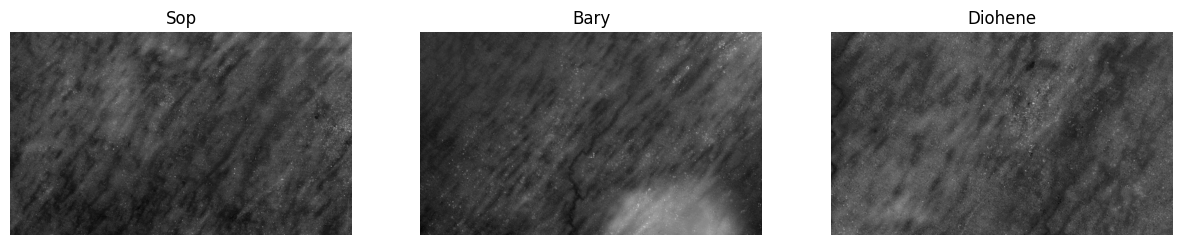

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_mnt_sop, cmap='gray')
axs[0].set_title('Sop')
axs[0].axis('off')

axs[1].imshow(img_mnt_bary, cmap='gray')
axs[1].set_title('Bary')
axs[1].axis('off')

axs[2].imshow(img_mnt_diohene, cmap='gray')
axs[2].set_title('Diohene')
axs[2].axis('off')

plt.show()


In [ ]:
img_sop = img_sop.transpose([1,2,0])
img_bary = img_bary.transpose([1,2,0])
img_diohene = img_diohene.transpose([1,2,0])

mnt_sop = img_mnt_sop
mnt_bary = img_mnt_bary
mnt_diohene = img_mnt_diohene

In [ ]:
img_sop.shape,img_bary.shape,img_diohene.shape,mnt_sop.shape

((489, 822, 13), (489, 822, 13), (489, 822, 13), (489, 822, 1))

(-0.5, 821.5, 488.5, -0.5)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


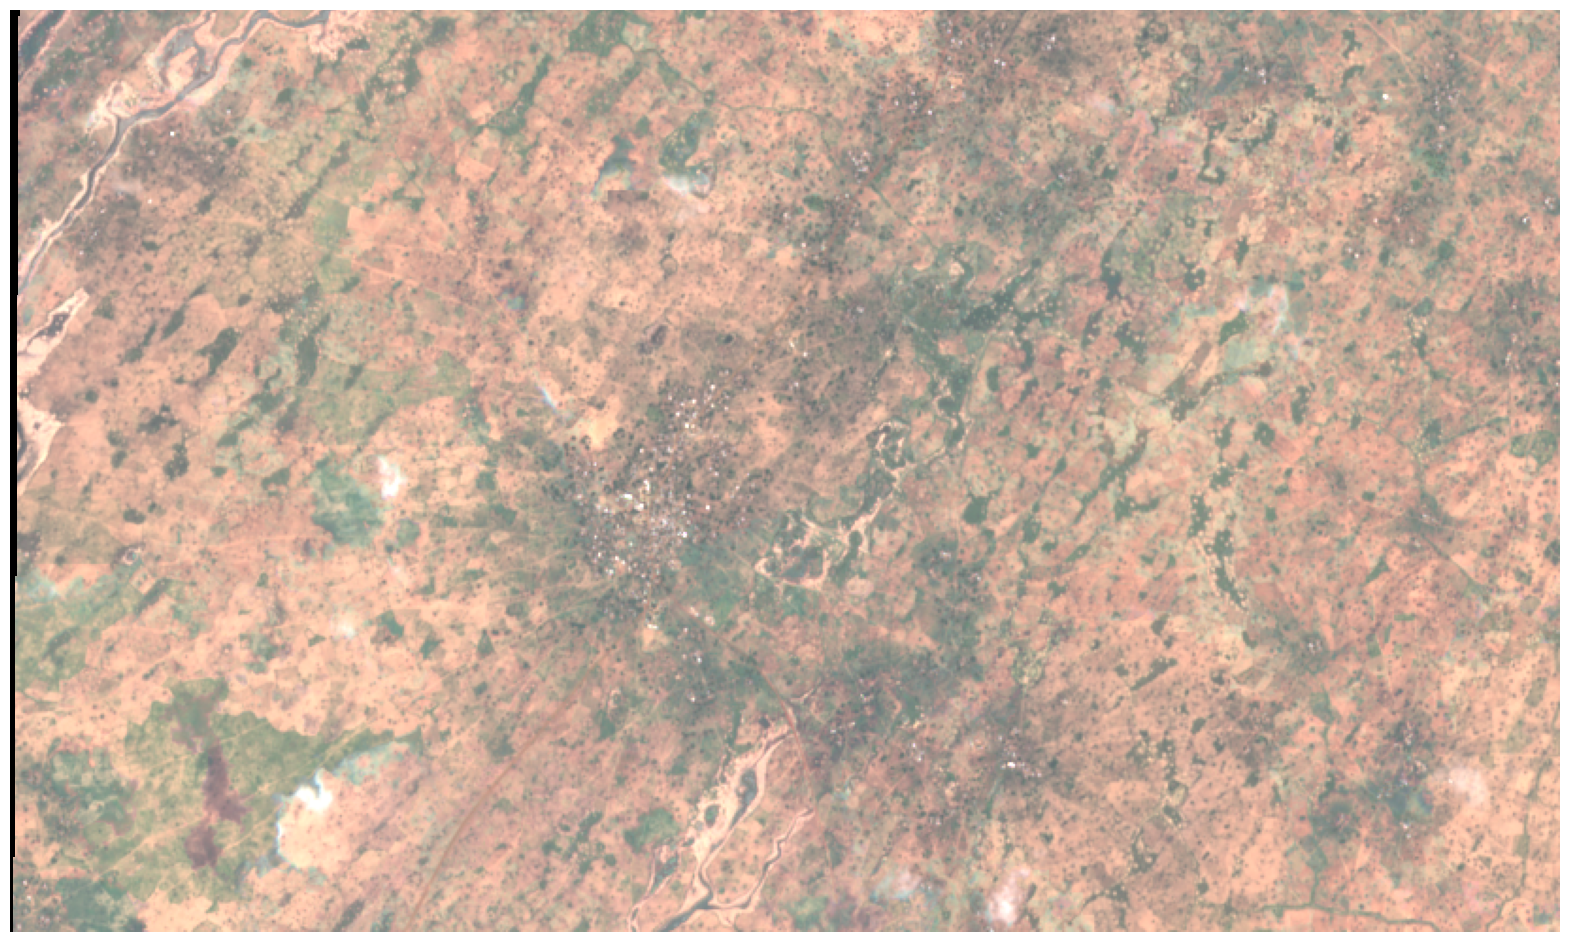

In [ ]:
red = img_diohene[:,:,3]
green = img_diohene[:,:,2]
blue = img_diohene[:,:,1]

rgb_sop = np.dstack((red,green,blue))

plt.figure(figsize=[20,20])
plt.imshow(rgb_sop*4)
plt.axis('off')

In [ ]:
sop_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/SOP/SOP_DATA.shp'
bary_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/BARY/BARY_DATA.shp'
diohene_shapefile_path = '/content/MyDrive/MyDrive/GEE_SOP/DIOHENE/DIOHENE_DATA.shp'

samples_sop = gpd.read_file(sop_shapefile_path)
samples_bary = gpd.read_file(bary_shapefile_path)
samples_diohene = gpd.read_file(diohene_shapefile_path)

In [ ]:
# samples_sop = samples_sop.to_crs('EPSG:4326')
# samples_bary = samples_bary.to_crs('EPSG:4326')
# samples_diohene = samples_diohene.to_crs('EPSG:4326')

In [ ]:
print(samples_sop.crs)
print(samples_bary.crs)
print(samples_diohene.crs)

EPSG:32628
EPSG:32628
EPSG:32628


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


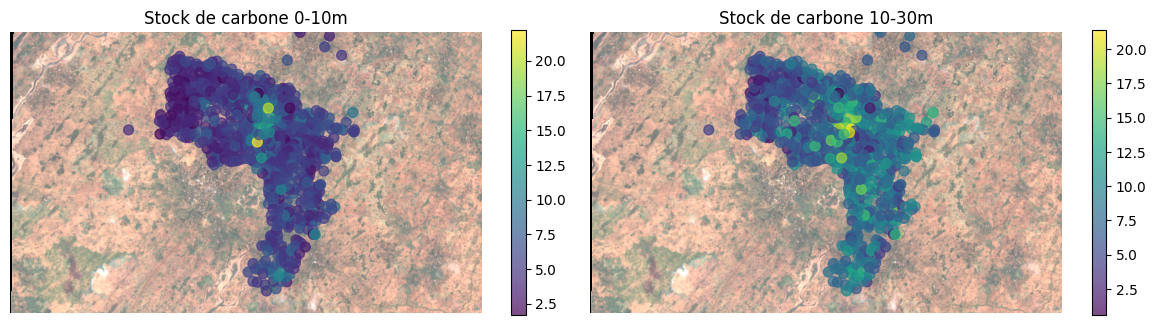

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.plot import show

cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 0-'], cmap=cmap, s=50, alpha=0.7)
cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('Stock de carbone 0-10m')
show(rgb_sop.transpose([2, 0, 1]) * 4, transform=sop.transform, ax=axs[0])
axs[0].axis('off')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 10'], cmap=cmap, s=50, alpha=0.7)
cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('Stock de carbone 10-30m')
show(rgb_sop.transpose([2, 0, 1]) * 4, transform=sop.transform, ax=axs[1])
axs[1].axis('off')

plt.tight_layout()
plt.show()


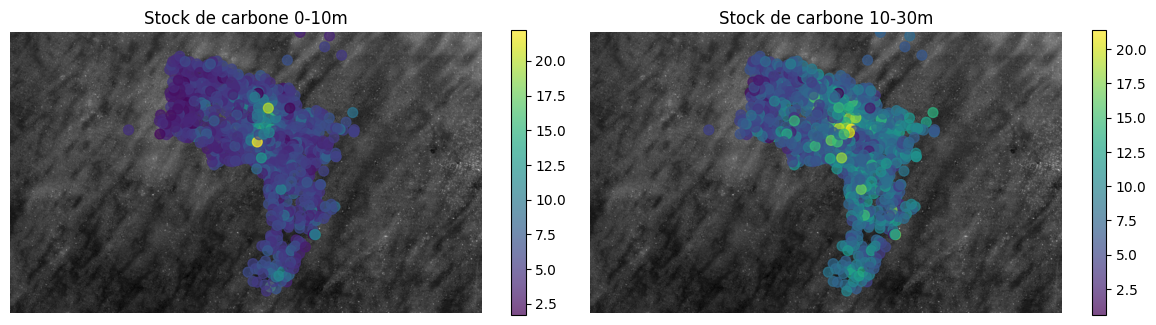

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 0-'], cmap=cmap, s=50, alpha=0.7)
cbar1 = plt.colorbar(cax1, ax=axs[0], shrink=0.5)
axs[0].set_title('Stock de carbone 0-10m')
show(mnt_sop, transform=sop.transform, ax=axs[0],cmap='gray')
axs[0].axis('off')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(samples_sop.geometry.x, samples_sop.geometry.y, c=samples_sop['Stock_C 10'], cmap=cmap, s=50, alpha=0.7)
cbar2 = plt.colorbar(cax2, ax=axs[1], shrink=0.5)
axs[1].set_title('Stock de carbone 10-30m')
show(mnt_sop, transform=sop.transform, ax=axs[1],cmap='gray')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Transformer l'image et le mnt pour la prédiction
predict_img_sop = np.nan_to_num(img_sop)
predict_img_sop = predict_img_sop.reshape(img_sop.shape[0]*img_sop.shape[1], img_sop.shape[2])

predict_mnt_sop = np.nan_to_num(mnt_sop)
predict_mnt_sop = predict_mnt_sop.reshape(mnt_sop.shape[0]*mnt_sop.shape[1], mnt_sop.shape[2])

predict_img_sop.shape,predict_mnt_sop.shape

((401958, 13), (401958, 1))

In [ ]:
predict_img_bary = np.nan_to_num(img_bary)
predict_img_bary = predict_img_bary.reshape(img_bary.shape[0]*img_bary.shape[1], img_bary.shape[2])

predict_mnt_bary = np.nan_to_num(mnt_bary)
predict_mnt_bary = predict_mnt_bary.reshape(mnt_bary.shape[0]*mnt_bary.shape[1], mnt_bary.shape[2])

predict_img_bary.shape,predict_mnt_bary.shape

((401958, 13), (401958, 1))

In [ ]:
predict_img_diohene = np.nan_to_num(img_diohene)
predict_img_diohene = predict_img_diohene.reshape(img_diohene.shape[0]*img_diohene.shape[1], img_diohene.shape[2])

predict_mnt_diohene = np.nan_to_num(mnt_diohene)
predict_mnt_diohene = predict_mnt_diohene.reshape(mnt_diohene.shape[0]*mnt_diohene.shape[1], mnt_diohene.shape[2])

predict_img_diohene.shape,predict_mnt_diohene.shape

((401958, 13), (401958, 1))

In [ ]:
array_depth_0_10 = np.full((predict_img_sop.shape[0], 1), 10)
array_depth_10_30 = np.full((predict_img_sop.shape[0], 1), 30)

In [ ]:
array_depth_0_10.shape,array_depth_10_30.shape

((401958, 1), (401958, 1))

In [ ]:
# def calculate_indices(bands):
#     # Extraire les valeurs de pixel des bandes par indice
#     B_1 = bands[:, 0]
#     B_2 = bands[:, 1]
#     B_3 = bands[:, 2]
#     B_4 = bands[:, 3]
#     B_5 = bands[:, 4]
#     B_6 = bands[:, 5]
#     B_7 = bands[:, 6]
#     B_8 = bands[:, 7]
#     B_8A = bands[:, 8]
#     B_9 = bands[:, 9]
#     B_10 = bands[:, 10]
#     B_11 = bands[:, 11]
#     B_12 = bands[:, 12]

#     # Calcul du NDVI
#     ndvi = (B_8 - B_4) / (B_8 + B_4)

#     # Calcul du GDVI
#     gdvi = (B_8 - B_3) / (B_8 + B_3)

#     # Calcul du MSAVI2
#     msavi2 = (2 * B_8 + 1 - np.sqrt((2 * B_8 + 1) ** 2 - 8 * (B_8 - B_4))) / 2

#     # Calcul du PSRINIR
#     psrinir = B_8 / B_5

#     # Calcul du NDWI
#     ndwi = (B_3 - B_8) / (B_3 + B_8)

#     # Calcul du CIGreen
#     cigreen = (B_4 - B_3) / (B_4 + B_3)

#     return pd.DataFrame({
#         'NDVI': ndvi,
#         'GDVI': gdvi,
#         'MSAVI2': msavi2,
#         'PSRINIR': psrinir,
#         'NDWI': ndwi,
#         'CIGreen': cigreen
#     })

In [ ]:
# indices_sop = calculate_indices(predict_img_sop)
# predict_img_sop = pd.concat([pd.DataFrame(predict_img_sop), indices_sop], axis=1)

# indices_bary = calculate_indices(predict_img_bary)
# predict_img_bary = pd.concat([pd.DataFrame(predict_img_bary), indices_bary], axis=1)

# indices_diohene = calculate_indices(predict_img_diohene)
# predict_img_diohene = pd.concat([pd.DataFrame(predict_img_diohene), indices_diohene], axis=1)

In [ ]:
array_depth_0_10 = pd.DataFrame(array_depth_0_10)
array_depth_10_30 = pd.DataFrame(array_depth_10_30)

samples_sop_mnt = pd.concat((pd.DataFrame(predict_img_sop), pd.DataFrame(predict_mnt_sop)), axis=1)
samples_sop_to_predict10 = pd.concat((samples_sop_mnt, array_depth_0_10), axis=1)
samples_sop_to_predict30 = pd.concat((samples_sop_mnt, array_depth_10_30), axis=1)

samples_bary_mnt = pd.concat((pd.DataFrame(predict_img_bary), pd.DataFrame(predict_mnt_bary)), axis=1)
samples_bary_to_predict10 = pd.concat((samples_bary_mnt, array_depth_0_10), axis=1)
samples_bary_to_predict30 = pd.concat((samples_bary_mnt, array_depth_10_30), axis=1)

samples_diohene_mnt = pd.concat((pd.DataFrame(predict_img_diohene), pd.DataFrame(predict_mnt_diohene)), axis=1)
samples_diohene_to_predict10 = pd.concat((samples_diohene_mnt, array_depth_0_10), axis=1)
samples_diohene_to_predict30 = pd.concat((samples_diohene_mnt, array_depth_10_30), axis=1)

In [ ]:
samples_sop_to_predict10.shape,samples_sop_to_predict30.shape

((401958, 15), (401958, 15))

In [ ]:
samples_sop_to_predict10 = np.array([samples_sop_to_predict10]).reshape(-1, samples_sop_to_predict10.shape[-1])
samples_sop_to_predict30 = np.array([samples_sop_to_predict30]).reshape(-1, samples_sop_to_predict30.shape[-1])

samples_bary_to_predict10 = np.array([samples_bary_to_predict10]).reshape(-1, samples_bary_to_predict10.shape[-1])
samples_bary_to_predict30 = np.array([samples_bary_to_predict30]).reshape(-1, samples_bary_to_predict30.shape[-1])

samples_diohene_to_predict10 = np.array([samples_diohene_to_predict10]).reshape(-1, samples_diohene_to_predict10.shape[-1])
samples_diohene_to_predict30 = np.array([samples_diohene_to_predict30]).reshape(-1, samples_diohene_to_predict30.shape[-1])

In [ ]:
from sklearn.impute import SimpleImputer

#Imputer les valeurs manquantes
imputer = SimpleImputer(strategy='median')

samples_sop_to_predict10_imputed = imputer.fit_transform(samples_sop_to_predict10)
samples_sop_to_predict30_imputed = imputer.fit_transform(samples_sop_to_predict30)

samples_bary_to_predict10_imputed = imputer.fit_transform(samples_bary_to_predict10)
samples_bary_to_predict30_imputed = imputer.fit_transform(samples_bary_to_predict30)

samples_diohene_to_predict10_imputed = imputer.fit_transform(samples_diohene_to_predict10)
samples_diohene_to_predict30_imputed = imputer.fit_transform(samples_diohene_to_predict30)

In [ ]:
# Faire des prédictions sur les données imputées
array_pred_sop10 = model_loaded.predict(samples_sop_to_predict10_imputed)
array_pred_sop10 = array_pred_sop10.reshape(img_sop.shape[0], img_sop.shape[1])

array_pred_sop30 = model_loaded.predict(samples_sop_to_predict30_imputed)
array_pred_sop30 = array_pred_sop30.reshape(img_sop.shape[0], img_sop.shape[1])

array_pred_bary10 = model_loaded.predict(samples_bary_to_predict10_imputed)
array_pred_bary10 = array_pred_bary10.reshape(img_bary.shape[0], img_bary.shape[1])

array_pred_bary30 = model_loaded.predict(samples_bary_to_predict30_imputed)
array_pred_bary30 = array_pred_bary30.reshape(img_bary.shape[0], img_bary.shape[1])

array_pred_diohene10 = model_loaded.predict(samples_diohene_to_predict10_imputed)
array_pred_diohene10 = array_pred_diohene10.reshape(img_diohene.shape[0], img_diohene.shape[1])

array_pred_diohene30 = model_loaded.predict(samples_diohene_to_predict30_imputed)
array_pred_diohene30 = array_pred_diohene30.reshape(img_diohene.shape[0], img_diohene.shape[1])

In [ ]:
np.max(array_pred_diohene10)

11.294098588489344

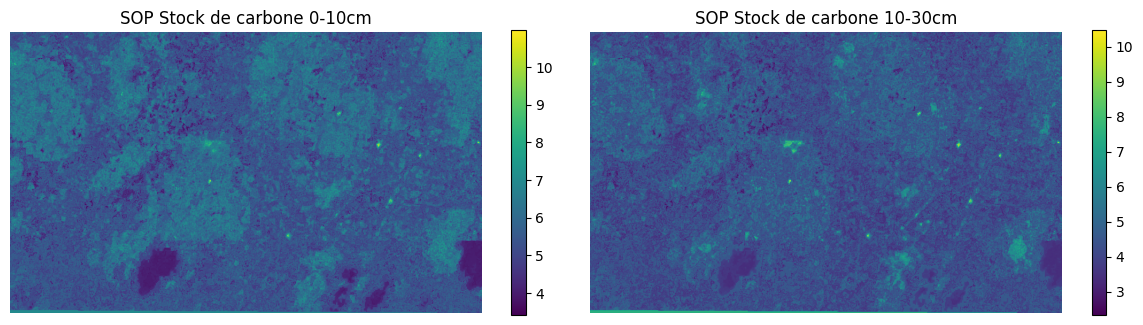

In [ ]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de SOP Stock de carbone 0-10cm
cax1 = axs[0].imshow(array_pred_sop10, cmap=cmap)
axs[0].set_title('SOP Stock de carbone 0-10cm')
axs[0].axis('off')

# Ajouter la barre de couleur pour SOP Stock de carbone 0-10cm
cbar1 = fig.colorbar(cax1, ax=axs[0], shrink=0.5)

# Affichage de SOP Stock de carbone 10-30cm
cax2 = axs[1].imshow(array_pred_sop30, cmap=cmap)
axs[1].set_title('SOP Stock de carbone 10-30cm')
axs[1].axis('off')

# Ajouter la barre de couleur pour SOP Stock de carbone 10-30cm
cbar2 = fig.colorbar(cax2, ax=axs[1], shrink=0.5)

plt.tight_layout()
plt.show()


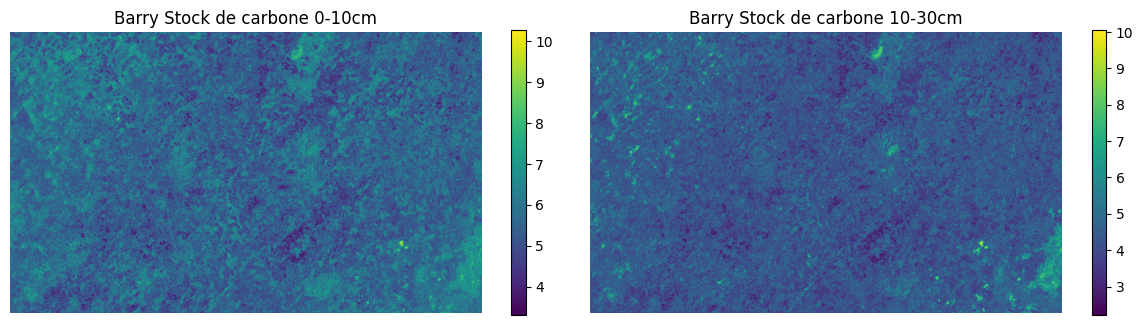

In [ ]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de Bary Stock de carbone 0-10cm
cax1 = axs[0].imshow(array_pred_bary10, cmap=cmap)
axs[0].set_title('Barry Stock de carbone 0-10cm')
axs[0].axis('off')

# Ajouter la barre de couleur pour Bary Stock de carbone 0-10cm
cbar1 = fig.colorbar(cax1, ax=axs[0], shrink=0.5)

# Affichage de Bary Stock de carbone 10-30cm
cax2 = axs[1].imshow(array_pred_bary30, cmap=cmap)
axs[1].set_title('Barry Stock de carbone 10-30cm')
axs[1].axis('off')

# Ajouter la barre de couleur pour Bary Stock de carbone 10-30cm
cbar2 = fig.colorbar(cax2, ax=axs[1], shrink=0.5)

plt.tight_layout()
plt.show()



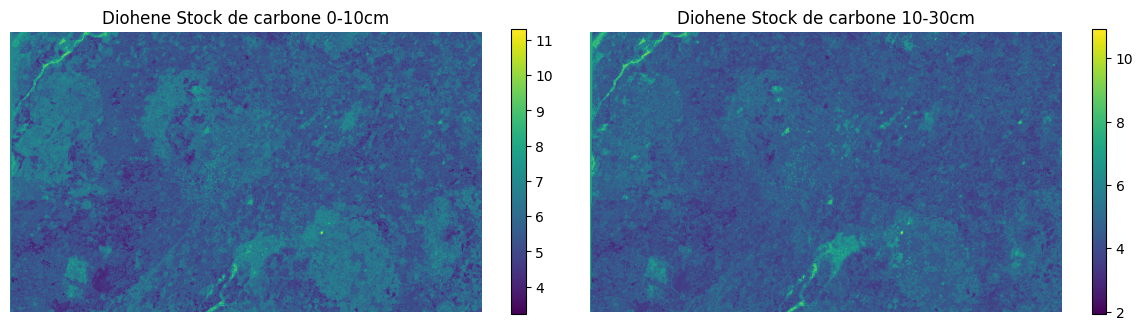

In [ ]:
# Afficher les résultats
cmap = 'viridis'

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage de Diohene Stock de carbone 0-10cm
cax1 = axs[0].imshow(array_pred_diohene10, cmap=cmap)
axs[0].set_title('Diohene Stock de carbone 0-10cm')
axs[0].axis('off')

# Ajouter la barre de couleur pour Diohene Stock de carbone 0-10cm
cbar1 = fig.colorbar(cax1, ax=axs[0], shrink=0.5)

# Affichage de Diohene Stock de carbone 10-30cm
cax2 = axs[1].imshow(array_pred_diohene30, cmap=cmap)
axs[1].set_title('Diohene Stock de carbone 10-30cm')
axs[1].axis('off')

# Ajouter la barre de couleur pour Diohene Stock de carbone 10-30cm
cbar2 = fig.colorbar(cax2, ax=axs[1], shrink=0.5)

plt.tight_layout()
plt.show()



In [ ]:
samples_sop = samples_sop.to_crs('EPSG:4326')
samples_bary = samples_bary.to_crs('EPSG:4326')
samples_diohene = samples_diohene.to_crs('EPSG:4326')


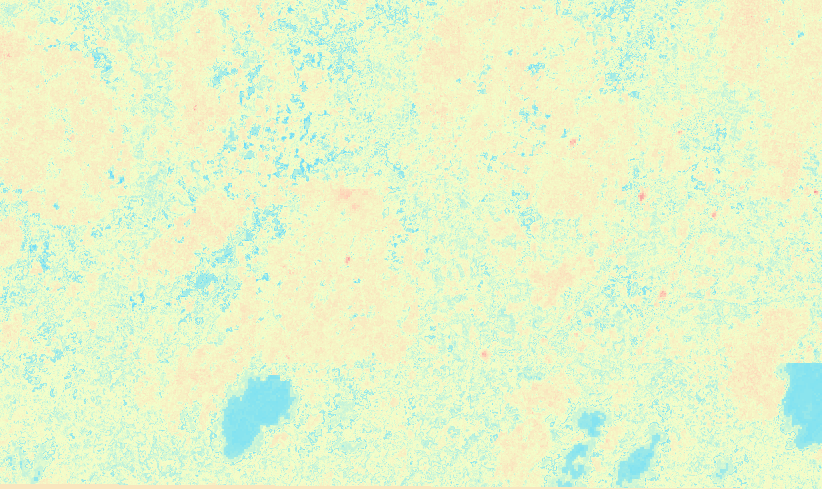
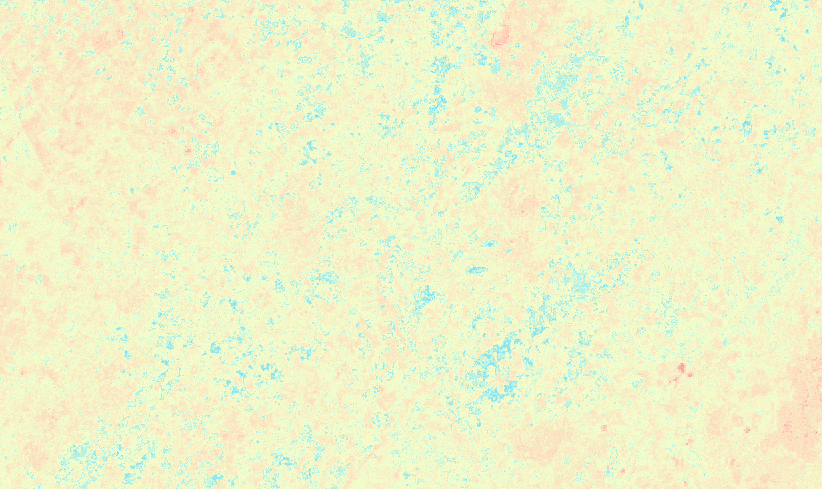
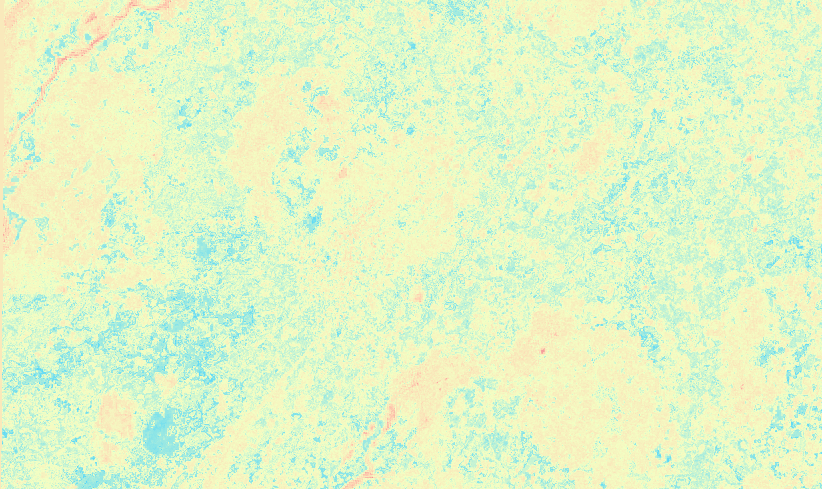

In [ ]:
import folium
import pyproj
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cm

# Créer une carte OpenStreetMap centrée sur les coordonnées moyennes
center_lat = np.mean(samples_sop.geometry.y)
center_lon = np.mean(samples_sop.geometry.x)
map_osm = folium.Map(
                    location=[center_lat, center_lon],
                    zoom_start=10,
                    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                    attr = 'Esri',
                    name = 'Esri Satellite'
                    )

color_bar = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

cmap = LinearSegmentedColormap.from_list('custom', color_bar)
colors_sop = cmap(array_pred_sop10 / np.max(array_pred_sop10))
colors_bary = cmap(array_pred_bary10 / np.max(array_pred_bary10))
colors_diohene = cmap(array_pred_diohene10 / np.max(array_pred_diohene10))

img_array_sop = np.zeros((len(array_pred_sop10), len(array_pred_sop10[0]), 4))
img_array_sop[:, :, :] = colors_sop

img_array_bary = np.zeros((len(array_pred_bary10), len(array_pred_bary10[0]), 4))
img_array_bary[:, :, :] = colors_bary

img_array_diohene = np.zeros((len(array_pred_diohene10), len(array_pred_diohene10[0]), 4))
img_array_diohene[:, :, :] = colors_diohene

img_array_sop[:, :, 3] = 0.6
img_array_bary[:, :, 3] = 0.6
img_array_diohene[:, :, 3] = 0.6

# Ajouter l'image à la carte en tant que superposition
img_overlay_sop = folium.raster_layers.ImageOverlay(
    image=img_array_sop,
    bounds=[[min(samples_sop.geometry.y), min(samples_sop.geometry.x)], [max(samples_sop.geometry.y), max(samples_sop.geometry.x)]],
    origin='upper'
).add_to(map_osm)

img_overlay_bary = folium.raster_layers.ImageOverlay(
    image=img_array_bary,
    bounds=[[min(samples_bary.geometry.y), min(samples_bary.geometry.x)], [max(samples_bary.geometry.y), max(samples_bary.geometry.x)]],
    origin='upper'
).add_to(map_osm)

img_overlay_diohene = folium.raster_layers.ImageOverlay(
    image=img_array_diohene,
    bounds=[[min(samples_diohene.geometry.y), min(samples_diohene.geometry.x)], [max(samples_diohene.geometry.y), max(samples_diohene.geometry.x)]],
    origin='upper'
).add_to(map_osm)

# Créer une colormap dynamique en fonction des valeurs min et max de array_pred_sop10
dynamic_colormap = cm.StepColormap(colors=color_bar, vmin=array_pred_sop10.min(), vmax=array_pred_sop10.max())

# Ajouter la colormap à la carte
map_osm.add_child(dynamic_colormap)

# Ajouter une légende pour la colormap
dynamic_colormap.caption = 'Valeurs de carbone entre 0 et 10 cm'
map_osm.add_child(dynamic_colormap)

# Afficher la carte
map_osm



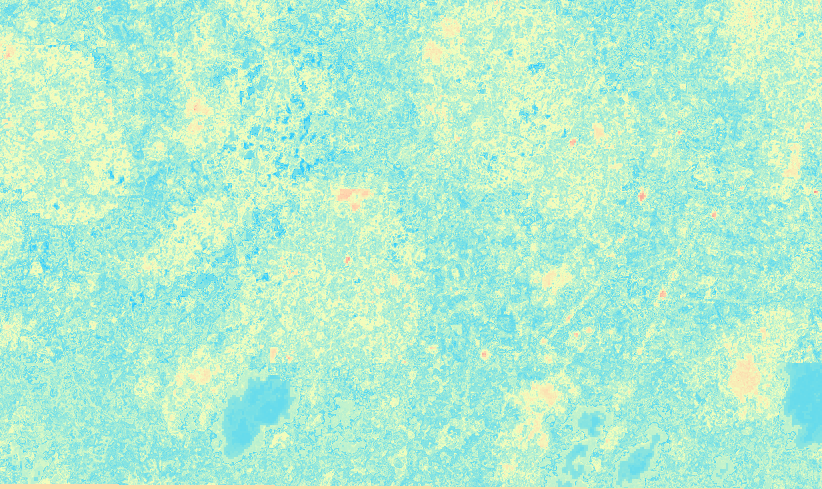
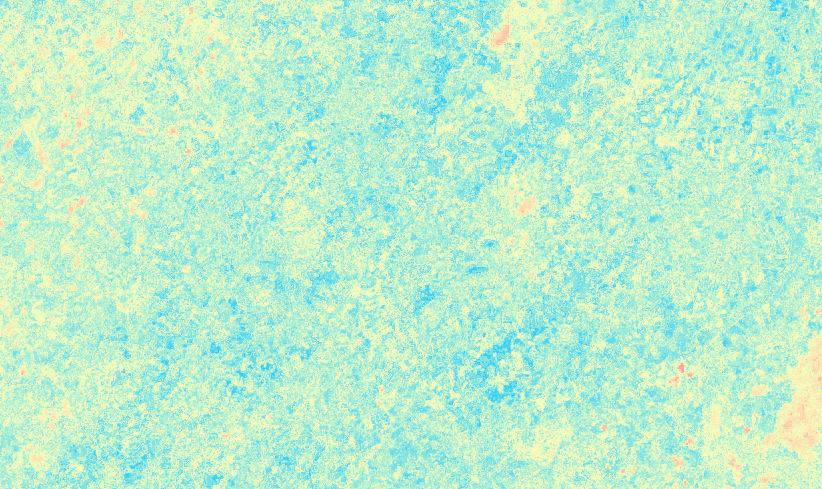
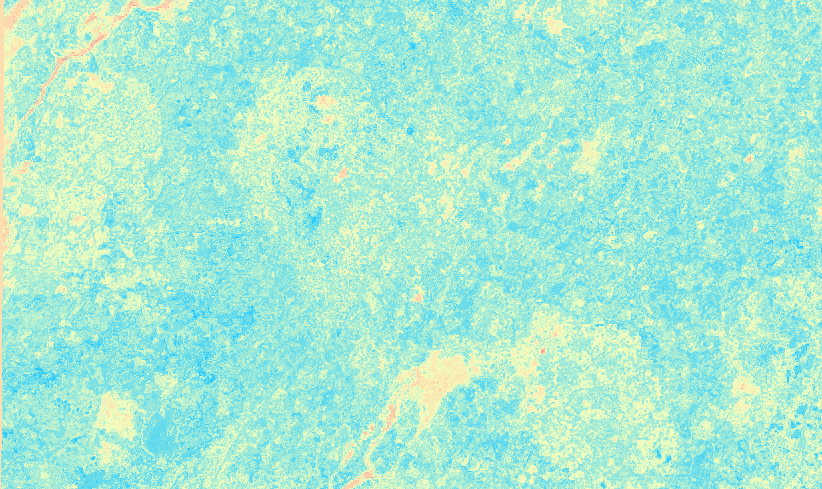

In [ ]:
import folium
import pyproj
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import branca.colormap as cm

# Créer une carte OpenStreetMap centrée sur les coordonnées moyennes
center_lat = np.mean(samples_sop.geometry.y)
center_lon = np.mean(samples_sop.geometry.x)
map_osm = folium.Map(
                    location=[center_lat, center_lon],
                    zoom_start=10,
                    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                    attr = 'Esri',
                    name = 'Esri Satellite'
                    )

color_bar = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

cmap = LinearSegmentedColormap.from_list('custom', color_bar)
colors_sop = cmap(array_pred_sop30 / np.max(array_pred_sop30))
colors_bary = cmap(array_pred_bary30 / np.max(array_pred_bary30))
colors_diohene = cmap(array_pred_diohene30 / np.max(array_pred_diohene30))

img_array_sop = np.zeros((len(array_pred_sop30), len(array_pred_sop30[0]), 4))
img_array_sop[:, :, :] = colors_sop

img_array_bary = np.zeros((len(array_pred_bary30), len(array_pred_bary30[0]), 4))
img_array_bary[:, :, :] = colors_bary

img_array_diohene = np.zeros((len(array_pred_diohene30), len(array_pred_diohene30[0]), 4))
img_array_diohene[:, :, :] = colors_diohene

img_array_sop[:, :, 3] = 0.6
img_array_bary[:, :, 3] = 0.6
img_array_diohene[:, :, 3] = 0.6

# Ajouter l'image à la carte en tant que superposition
img_overlay_sop = folium.raster_layers.ImageOverlay(
    image=img_array_sop,
    bounds=[[min(samples_sop.geometry.y), min(samples_sop.geometry.x)], [max(samples_sop.geometry.y), max(samples_sop.geometry.x)]],
    origin='upper'
).add_to(map_osm)

img_overlay_bary = folium.raster_layers.ImageOverlay(
    image=img_array_bary,
    bounds=[[min(samples_bary.geometry.y), min(samples_bary.geometry.x)], [max(samples_bary.geometry.y), max(samples_bary.geometry.x)]],
    origin='upper'
).add_to(map_osm)

img_overlay_diohene = folium.raster_layers.ImageOverlay(
    image=img_array_diohene,
    bounds=[[min(samples_diohene.geometry.y), min(samples_diohene.geometry.x)], [max(samples_diohene.geometry.y), max(samples_diohene.geometry.x)]],
    origin='upper'
).add_to(map_osm)

# Créer une colormap dynamique en fonction des valeurs min et max de array_pred_sop30
dynamic_colormap = cm.StepColormap(colors=color_bar, vmin=array_pred_sop30.min(), vmax=array_pred_sop30.max())

# Ajouter la colormap à la carte
map_osm.add_child(dynamic_colormap)

# Ajouter une légende pour la colormap
dynamic_colormap.caption = 'Valeurs de carbone entre 10 et 30 cm'
map_osm.add_child(dynamic_colormap)

# Afficher la carte
map_osm
